In [1]:
import os
os.getcwd()

from dask.distributed import Client
client = Client(processes=False, threads_per_worker=30,
                n_workers=5)
from dask import delayed

In [2]:
#Import csv
import dask.array as da
import numpy as np
csv_path = os.getcwd() + '/obsInt_obsTime_with_variables.csv'
Z = da.from_array(np.loadtxt(csv_path, dtype=np.float, delimiter=",", skiprows=1))

In [3]:
#Splitting the data
from dask_ml.model_selection import train_test_split
y = Z[:, -1]
x = Z[:, 3:-2]
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size = 0.5, train_size = 0.5)

In [4]:
#Checking array sizes
print(Z.shape)
print(xtrain.shape, xtest.shape)
print(ytrain.shape, ytest.shape)

(7270756, 9)
(3635376, 4) (3635380, 4)
(3635376,) (3635380,)


In [5]:
#Making random forest algorithm
from sklearn.ensemble import RandomForestRegressor
from joblib import parallel_backend
rf = RandomForestRegressor(n_estimators=10, criterion="mse", max_depth=None, max_features="auto", bootstrap=True,
                           min_samples_split=2, n_jobs=1)
rf

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)

In [6]:
from dask_ml.metrics import r2_score
labels = ["temper", "precip", "pop", "roadlen"]
with parallel_backend('dask'):
    %time _ = rf.fit(xtrain, ytrain)
    ypred = rf.predict(xtest)
    zipped_rf = list (zip (labels, rf.feature_importances_))
print("RF: ", r2_score(ytest, ypred))
print(zipped_rf)

CPU times: user 5min 41s, sys: 1.49 s, total: 5min 42s
Wall time: 53.9 s
RF:  -0.35181494011471925
[('temper', 0.029623059775310656), ('precip', 0.5241645657048587), ('pop', 0.3900753021864718), ('roadlen', 0.05613707233335887)]


In [7]:
import matplotlib.pyplot as plt
#Plotting matrices
plt.subplot(3, 6, 6)
plt.title("Performance in Observer Intensity (R2: {0})".format(r2_score(ytest, ypred)), size=10)
plt.plot(ypred, ytest, "o")
plt.plot(ypred, ypred, "r-", linewidth=2)
plt.xlabel("Predicted obsint", size=10)
plt.ylabel("True obsint", size=10)
plt.xlim(0, 300)
plt.grid()
plt.show()

<Figure size 640x480 with 1 Axes>

In [8]:
#Making data arrays for map visualisation
path_nl = os.getcwd() + '/obsInt_obsTime_with_variables.csv'
xtestnl = np.loadtxt(path_nl, usecols=list(range(4, 8)), dtype=np.float, delimiter=",", skiprows = 1)
metadata = da.from_array(np.loadtxt(path_nl, usecols=(0, 1, 2, 3), dtype=np.float, delimiter=",", skiprows = 1))

In [9]:
#Creating stack
yprednl = da.from_array(rf.predict(xtestnl).reshape(-1, 1))
yprednl = da.array(yprednl, int)
metadata = da.array(metadata, int)
stack = da.hstack((metadata, yprednl))

stack

dask.array<concatenate, shape=(7270756, 5), dtype=int64, chunksize=(3635378, 4)>

In [10]:
#Creating stack pixel for the map
def place_pixel(stack):
    placed = np.multiply(np.ones((350, 300)), -1)
    for position in stack:
        row = position[1]
        col = position[2]
        value = position[3]
        placed[row, col] = value
    return placed

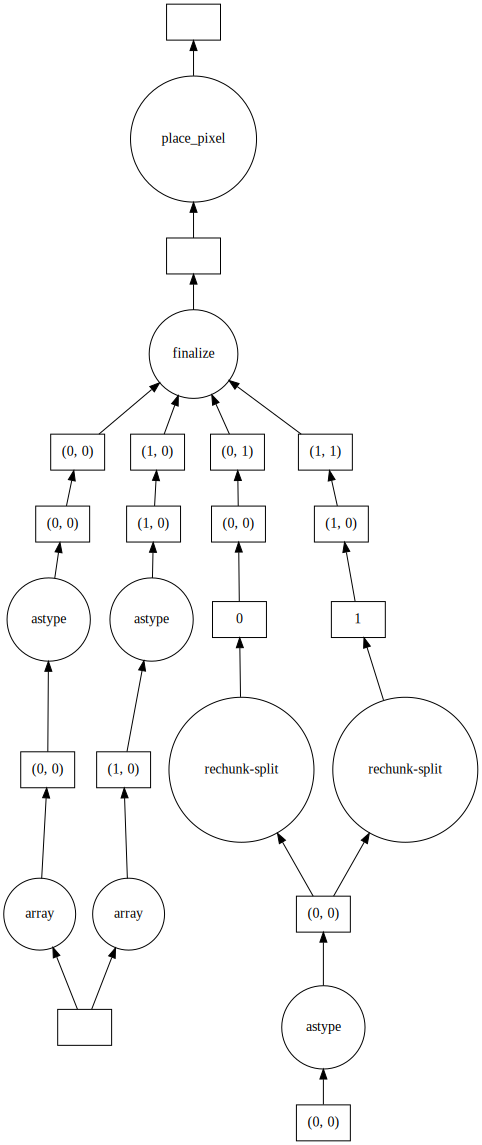

In [11]:
#Creating delayed object for the map visualisation
map = delayed(place_pixel)(stack)
map.visualize(filename='geo.svg')

distributed.worker - WARNING -  Compute Failed
Function:  place_pixel
args:      (array([[      98,       16,      375,        0,        3],
       [     171,       18,      379,        0,        4],
       [     195,       19,      365,        0,       12],
       ...,
       [   44607,      209,      355, 15379200,        2],
       [   44607,      209,      355, 15465600,        3],
       [   44607,      209,      355, 15552000,        6]]))
kwargs:    {}
Exception: IndexError('index 375 is out of bounds for axis 1 with size 300',)



IndexError: index 375 is out of bounds for axis 1 with size 300

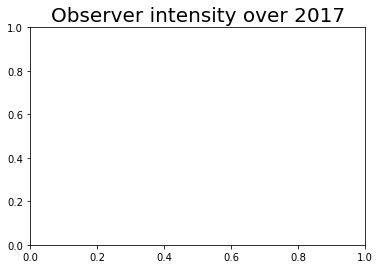

In [12]:
#Final visualisation
plt.clf()
plt.title("Observer intensity over 2017", size=20)
plt.imshow(map.compute(), interpolation="None", cmap=plt.get_cmap("nipy_spectral"))
plt.colorbar()
plt.show()
#Still researching this error